### 0. Notebook setup

In [108]:
COLAB = False # Set this to True if you want to install the libraries and clone the repository in Colab
USE_DOTENV = True # Set this to False if you don't have a .env file for storing environment variables

if COLAB:
    USE_DOTENV = False
    dotenv_path = None
    from google.colab import userdata
    colab_secrets = {'HF_TOKEN': userdata.get('HF_TOKEN'), 'HF_TOKEN_WRITE': userdata.get('HF_TOKEN_WRITE')}
    !pip install datasets
    !git clone https://github.com/reddgr/zero-shot-text-classification
    import os
    os.system("mv zero-shot-text-classification zs_tc")

if USE_DOTENV: 
    COLAB=False
    dotenv_path = "../../../../../apis/.env"
    colab_secrets = None

from transformers import pipeline, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, AutoTokenizer,  AdamW, Trainer, TrainingArguments
import tensorflow as tf
import random
from datasets import load_dataset, Dataset
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import sys
import os
import torch
import textwrap
from IPython.display import clear_output
import matplotlib.pyplot as plt

if COLAB:
    import sys
    sys.path.append("./zs_tc/src")
    import env_options, nli_labeling_widget as labeling_widget, text_classification_functions as tcf, lmsys_dataset_handler as lmsys
else:
    import sys
    sys.path.append("./src")
    import text_classification_functions as tcf
    import env_options
    import lmsys_dataset_handler as lmsys
    import nli_finetuning_utils

hf_token, hf_token_write, openai_api_key = env_options.check_env(colab=COLAB, use_dotenv=USE_DOTENV, 
                                                 dotenv_path=dotenv_path, colab_secrets=colab_secrets)

Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
PyTorch version: 2.2.2
Transformers version: 4.44.2
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA Version: 12.1
FlashAttention available: True
Retrieved token(s) from .env file
Using HuggingFace token: hf_M*****************************IASJ
Using HuggingFace write token: hf_u*****************************Xipx
Using OpenAI token: sk-p************************************************************************************************************************************************************_5sA


In [37]:
### DEBUG ###
import importlib
importlib.reload(nli_finetuning_utils)
importlib.reload(tcf)
### DEBUG ###

<module 'text_classification_functions' from 'c:\\Users\\david\\Documents\\python_scripts\\nli_finetuning\\./src\\text_classification_functions.py'>

### Loading the Test split of the dataset

In [109]:
test_dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
print("Labels: ",test_dataset_dict["test"].features["label"]._str2int)
entailments_test_dataset_df = test_dataset_df[test_dataset_df['label'] == 2]
display(entailments_test_dataset_df.head(3))
print(f'... {len(entailments_test_dataset_df)} records ...')
display(entailments_test_dataset_df.tail(3))

Labels:  {'contradiction': 0, 'neutral': 1, 'entailment': 2}


,text,category,label
5,I wanna have a conversation in german to practice,language,2
7,What you think about Belarus?,general knowledge,2
9,What does LLaMA means?,technology,2


... 202 records ...


,text,category,label
364,"how can I translate ""self-deprecating"" to Span...",language,2
367,"os.environ[""KERAS_BACKEND""] = ""jax"" # or ""ten...",coding,2
370,The only book I have read by Stanislaw Lem is ...,books,2


## Top-12 categories excluding "general knowledge"

In [110]:
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_display = 15
print(f'Top {top_n_display} prompt categories:\n{category_counts.head(top_n_display)}')
category_counts = category_counts[category_counts.index != 'general knowledge']
top_n_categories = 12
top_categories = category_counts.head(top_n_categories).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
print(f'{len(test_entailments_df)} records for testing {top_n_categories} categories')
test_entailments_dataset = Dataset.from_pandas(test_entailments_df)
print(test_entailments_dataset)
print(top_categories.to_list())

Top 15 prompt categories:
category
coding               33
technology           29
writing              23
language             20
science              19
business             14
popular culture      11
riddle                9
role play             9
general knowledge     8
finance               5
ai                    4
philosophy            4
images                3
politics              3
Name: count, dtype: int64
180 records for testing 12 categories
Dataset({
    features: ['text', 'category', 'label', '__index_level_0__'],
    num_rows: 180
})
['coding', 'technology', 'writing', 'language', 'science', 'business', 'popular culture', 'riddle', 'role play', 'finance', 'ai', 'philosophy']


Instantiating the zero-shot classifiers:

In [111]:
nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)

base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, base_model_path, top_categories)

c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Zero-shot classification examples:

In [112]:
text_sample = test_entailments_df.sample(1).text.values[0]
# text_sample = "I'm twice the age you were when i was your age. How old are we?"
ft_result = zs_classifier.classify_text(text_sample, multi_label=False)
base_result = base_classifier.classify_text(text_sample, multi_label=False)
clear_output(wait=True)
print("Classification with fine-tuned model:")
for key, value in ft_result.items():
    print(f"{key}: {value}")

print("Classification with base model:")
for key, value in base_result.items():
    print(f"{key}: {value}")

Classification with fine-tuned model:
sequence: How many languages do you understand?
labels: ['language', 'ai', 'riddle', 'role play', 'business', 'popular culture', 'writing', 'philosophy', 'technology', 'coding', 'science', 'finance']
scores: [0.477, 0.143, 0.136, 0.056, 0.03, 0.027, 0.026, 0.024, 0.022, 0.021, 0.021, 0.017]
Classification with base model:
sequence: How many languages do you understand?
labels: ['language', 'riddle', 'ai', 'role play', 'writing', 'coding', 'popular culture', 'technology', 'philosophy', 'business', 'science', 'finance']
scores: [0.6, 0.269, 0.038, 0.021, 0.017, 0.011, 0.009, 0.009, 0.008, 0.007, 0.007, 0.006]


In [73]:
df_testing = test_entailments_df.sample(10).copy()
df_testing_zs = zs_classifier.classify_dataframe_column(df_testing, target_column = 'text', feature_suffix = 'zs')
# Add a column to indicate if the prediction was correct
df_testing_zs['is_correct'] = (
    df_testing_zs['category'] == df_testing_zs['top_class_zs']
).astype(int)
# Calculate accuracy of the sample:
sample_accuracy = df_testing_zs['is_correct'].mean() * 100
print(f"Sample accuracy: {sample_accuracy:.1f}%")
display(df_testing_zs)

100%|██████████| 10/10 [00:07<00:00,  1.30it/s]

Sample accuracy: 60.0%


,text,category,label,top_class_zs,top_score_zs,full_results_zs,is_correct
270,"For example, it's like noticing that the inhab...",philosophy,2,technology,0.247,"[(technology, 0.247), (role play, 0.233), (ai,...",0
98,Explain what networking lessons we can learn f...,popular culture,2,popular culture,0.481,"[(popular culture, 0.481), (ai, 0.196), (busin...",1
237,what are water molecules?,science,2,science,0.795,"[(science, 0.795), (riddle, 0.09), (ai, 0.036)...",1
113,"I think ""how the world is in a race again the ...",language,2,language,0.549,"[(language, 0.549), (writing, 0.112), (ai, 0.1...",1
78,"Wehn I was six, my sister was half my age. Now...",riddle,2,ai,0.228,"[(ai, 0.228), (riddle, 0.212), (role play, 0.2...",0
213,Are you in anyway related to NAME_1 in strange...,popular culture,2,riddle,0.305,"[(riddle, 0.305), (ai, 0.176), (popular cultur...",0
340,what is the function in R base library to do a...,coding,2,coding,0.689,"[(coding, 0.689), (technology, 0.153), (ai, 0....",1
279,what kind of AI language model are you?,ai,2,technology,0.580,"[(technology, 0.58), (language, 0.141), (ai, 0...",0
15,Give me a shortlist of free to use AI chatbots...,technology,2,technology,0.621,"[(technology, 0.621), (ai, 0.104), (coding, 0....",1
11,Give me a creative sentence for a closed ended...,language,2,language,0.375,"[(language, 0.375), (writing, 0.287), (busines...",1


Zero-shot classification with facebook/bart-large-mnli:   0%|          | 0/180 [00:00<?, ?it/s]

Zero-shot classification with facebook/bart-large-mnli: 100%|██████████| 180/180 [00:43<00:00,  4.14it/s]


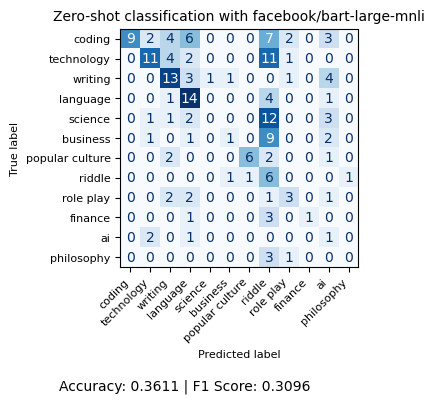

In [113]:
base_test_metrics = base_classifier.test_zs_predictions(test_entailments_df)

Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft: 100%|██████████| 180/180 [04:16<00:00,  1.42s/it]


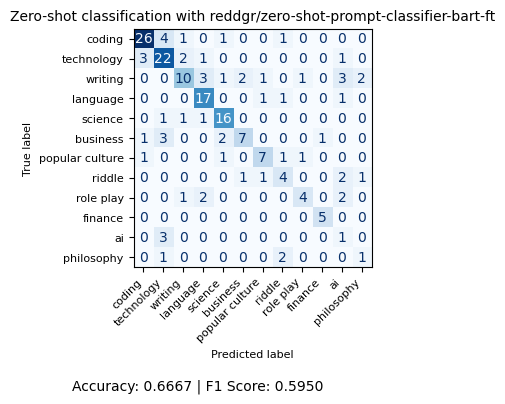

In [114]:
zs_test_metrics = zs_classifier.test_zs_predictions(test_entailments_df)

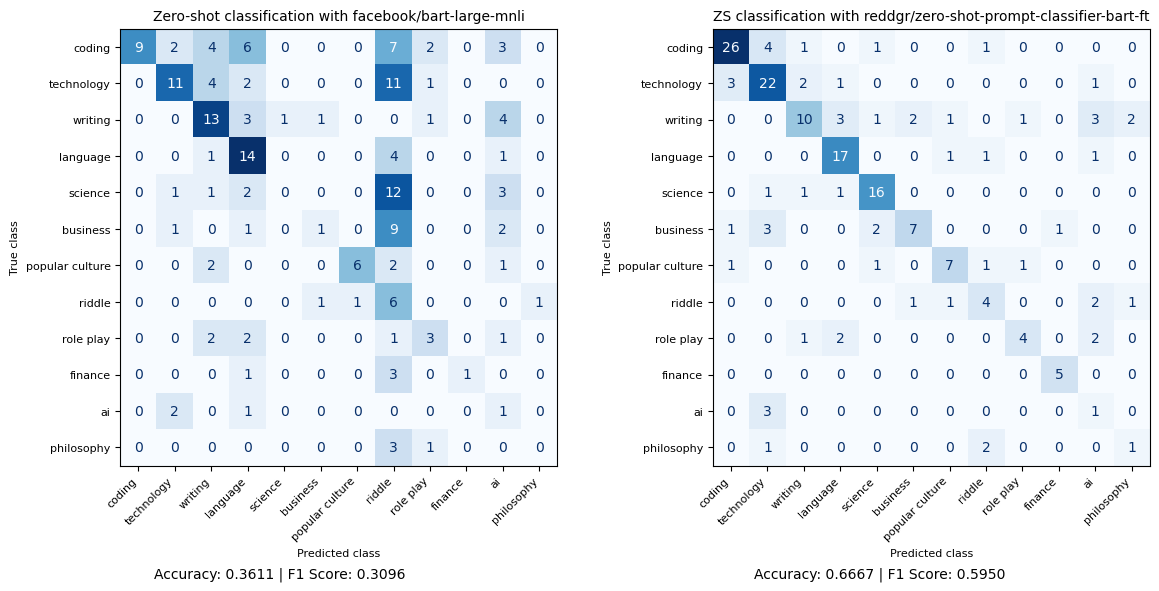

In [115]:
metrics_comp = tcf.MetricsComparison(base_classifier, zs_classifier, base_test_metrics, zs_test_metrics)
metrics_comp.compare_conf_matrices()

## Top-10 Categories

In [116]:
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_display = 12
print(f'Top {top_n_display} prompt categories:\n{category_counts.head(top_n_display)}')
category_counts = category_counts[category_counts.index != 'general knowledge']
top_n_categories = 10
top_categories = category_counts.head(top_n_categories).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
print(f'{len(test_entailments_df)} records for testing {top_n_categories} categories')
print(top_categories.to_list())

nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)

base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, base_model_path, top_categories)

Top 12 prompt categories:
category
coding               33
technology           29
writing              23
language             20
science              19
business             14
popular culture      11
riddle                9
role play             9
general knowledge     8
finance               5
ai                    4
Name: count, dtype: int64
172 records for testing 10 categories
['coding', 'technology', 'writing', 'language', 'science', 'business', 'popular culture', 'riddle', 'role play', 'finance']


c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [78]:
base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, base_model_path, top_categories)
nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)
base_test_metrics = base_classifier.test_zs_predictions(test_entailments_df, plot_conf_matrix=False)
zs_test_metrics = zs_classifier.test_zs_predictions(test_entailments_df, plot_conf_matrix=False)

Zero-shot classification with facebook/bart-large-mnli: 100%|██████████| 180/180 [08:17<00:00,  2.77s/it]
Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft: 100%|██████████| 180/180 [00:41<00:00,  4.34it/s]


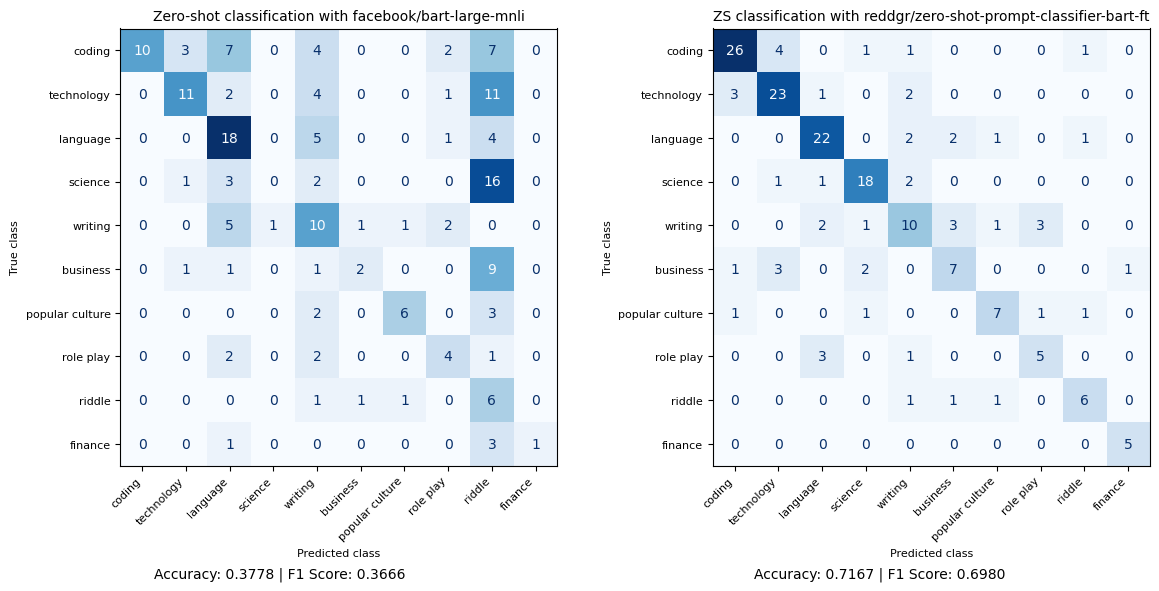

In [79]:
metrics_comp = tcf.MetricsComparison(base_classifier, zs_classifier, base_test_metrics, zs_test_metrics)
metrics_comp.compare_conf_matrices()

In [80]:
zs_test_metrics.get('detailed_results')
results_df = pd.DataFrame(zs_test_metrics['detailed_results'])
results_by_category = results_df.groupby(['category', 'predicted_class']).size().unstack(fill_value=0)
accuracy_by_category = results_df.groupby('category').apply(lambda x: (x['category'] == x['predicted_class']).mean())

print("\nAccuracy by category:")
for category in top_categories:
    print(f"{category:20} {accuracy_by_category[category]:.3f}")

print("\nResults sample:")
display(results_df.sample(5))


Accuracy by category:
coding               0.788
technology           0.793
language             0.786
science              0.818
writing              0.500
business             0.500
popular culture      0.636
role play            0.556
riddle               0.667
finance              1.000

Results sample:


,text,category,label,predicted_class
35,Do you know the song “Shout” by Tears for Fears?,popular culture,2,popular culture
318,<span>Enterprise Value/EBITDA</span> <sup aria...,coding,2,coding
372,"how can I translate ""self-deprecating"" to Span...",language,2,language
56,You and I meet for the first time. You are a g...,role play,2,role play
124,Who are the suppliers of Anti-Malarial medicin...,business,2,business


In [ ]:
# text_sample = test_entailments_df.sample(1).text.values[0]
text_sample = "I'm twice the age you were when i was your age. How old are we?"
ft_result = zs_classifier.classify_text(text_sample, multi_label=False)
base_result = base_classifier.classify_text(text_sample, multi_label=False)
clear_output(wait=True)
print("Classification with fine-tuned model:")
for key, value in ft_result.items():
    print(f"{key}: {value}")

print("Classification with base model:")
for key, value in base_result.items():
    print(f"{key}: {value}")

## 6 TTCB Grouped Categories

In [81]:
test_df_grouped = entailments_test_dataset_df.copy()
# test_df_grouped = test_entailments_df.copy()
test_df_grouped.loc[test_df_grouped['category'] == 'business', 'category'] = 'business and finance'
test_df_grouped.loc[test_df_grouped['category'] == 'finance', 'category'] = 'business and finance'
test_df_grouped.loc[test_df_grouped['category'] == 'language', 'category'] = 'language and writing'
test_df_grouped.loc[test_df_grouped['category'] == 'writing', 'category'] = 'language and writing'
test_df_grouped.loc[test_df_grouped['category'] == 'popular culture', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'music', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'entertainment', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'technology', 'category'] = 'technology and ai'
test_df_grouped.loc[test_df_grouped['category'] == 'ai', 'category'] = 'technology and ai'

In [82]:
category_counts = test_df_grouped['category'].value_counts()
top_n_display = 10
print(f'Top {top_n_display} prompt categories:\n{category_counts.head(top_n_display)}')
category_counts = category_counts[category_counts.index != 'general knowledge']
top_n_categories = 6
top_categories = category_counts.head(top_n_categories).index
test_entailments_grouped = test_df_grouped[test_df_grouped['category'].isin(top_categories)]
print(f'{len(test_entailments_grouped)} records for testing {top_n_categories} category groups')
print(top_categories.to_list())

Top 10 prompt categories:
category
language and writing         48
technology and ai            33
coding                       33
science                      22
business and finance         19
culture and entertainment    13
riddle                        9
role play                     9
general knowledge             8
philosophy                    4
Name: count, dtype: int64
168 records for testing 6 category groups
['language and writing', 'technology and ai', 'coding', 'science', 'business and finance', 'culture and entertainment']


Initializing the classifiers:

In [83]:
base_classifier = tcf.ZeroShotClassifier('facebook/bart-large-mnli', base_model_path, top_categories)
zs_classifier = tcf.ZeroShotClassifier('reddgr/zero-shot-prompt-classifier-bart-ft', nli_model_path, top_categories)
base_test_metrics = base_classifier.test_zs_predictions(test_entailments_grouped, plot_conf_matrix=False)
zs_test_metrics = zs_classifier.test_zs_predictions(test_entailments_grouped, plot_conf_matrix=False)

c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Zero-shot classification with facebook/bart-large-mnli: 100%|██████████| 168/168 [00:20<00:00,  8.16it/s]
Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft: 100%|██████████| 168/168 [01:20<00:00,  2.10it/s]


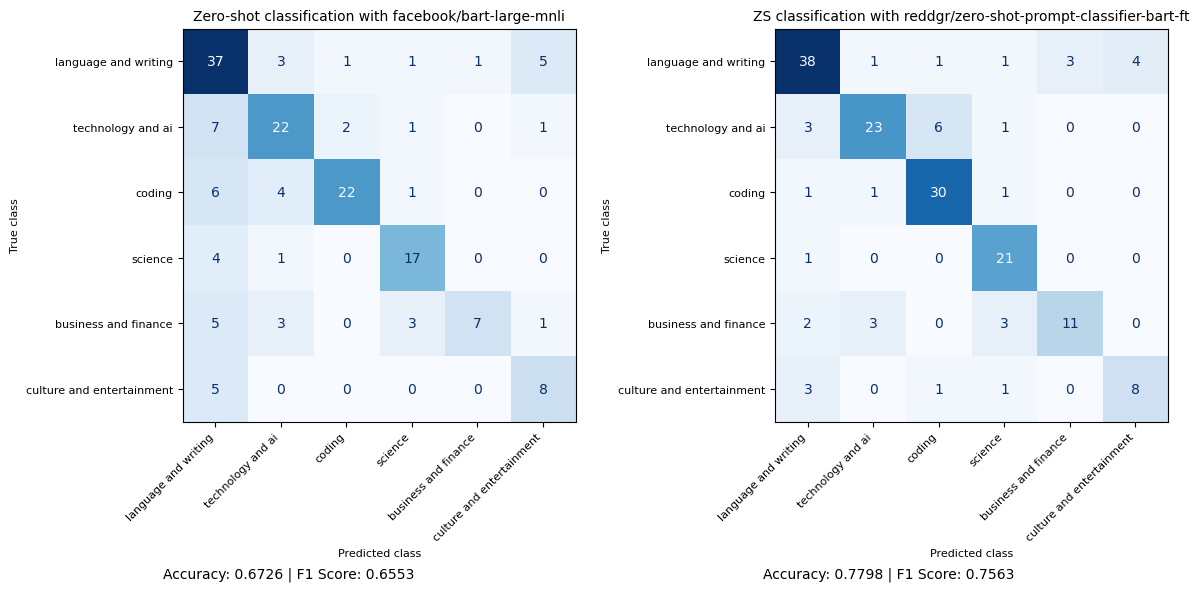

In [84]:
metrics_comp = tcf.MetricsComparison(base_classifier, zs_classifier, base_test_metrics, zs_test_metrics)
metrics_comp.compare_conf_matrices()

______________________________

### Dataset edits

In [102]:
test_dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
print("Labels: ",test_dataset_dict["test"].features["label"]._str2int)
display(test_dataset_df.sample(3))

Labels:  {'contradiction': 0, 'neutral': 1, 'entailment': 2}


,text,category,label
79,what is the conflict between israel and palest...,role play,0
134,"“Ok girls, bras off “ said NAME_2.",role play,2
113,"I think ""how the world is in a race again the ...",language,2


In [101]:
text = "sumarize the the answer in a couple"
test_dataset_df[test_dataset_df['text'].str.contains(text)]

,text,category,label
33,Can you sumarize the the answer in a couple of...,writing,2


In [103]:
text = "sumarize the the answer in a couple"
test_dataset_df.loc[(test_dataset_df['text'].str.contains(text)) 
                    & (test_dataset_df['label'] == 2), 'category'] = 'writing'

text = "correct the spelling for the following text"
test_dataset_df.loc[(test_dataset_df['text'].str.contains(text)) 
                    & (test_dataset_df['label'] == 2), 'category'] = 'writing'

text = "Write below sentence in an alternative way"
test_dataset_df.loc[(test_dataset_df['text'].str.contains(text)) 
                    & (test_dataset_df['label'] == 2), 'category'] = 'writing'

text = "work is a system of inputs that generates wealth for both the business and"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

text = "but make the responses more succinct and try skipping"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)


text = "discuss your idea to avoid wasting time"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)


text = "This comment was written with ChatGPT assistance"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

In [104]:
from datasets import Dataset, ClassLabel
test_dataset_new = Dataset.from_pandas(test_dataset_df, preserve_index=False)
print(test_dataset_new)

Dataset({
    features: ['text', 'category', 'label'],
    num_rows: 371
})


In [105]:
label_map = {0: "contradiction",1: "neutral",2: "entailment"}
class_label = ClassLabel(names=[label_map[i] for i in sorted(label_map.keys())])
# Map the 'label' feature to the new ClassLabel feature
def map_labels(example):
    example['label'] = class_label.str2int(label_map[example['label']])
    return example
test_dataset_new = test_dataset_new.map(map_labels)
test_dataset_new = test_dataset_new.cast_column("label", class_label)

Map:   0%|          | 0/371 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/371 [00:00<?, ? examples/s]

In [106]:
test_dataset_new.push_to_hub("reddgr/nli-chatbot-prompt-categorization", token=hf_token_write, split='test')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/reddgr/nli-chatbot-prompt-categorization/commit/51327f4a8989baeaa1891d69188b27d5d9c02423', commit_message='Upload dataset', commit_description='', oid='51327f4a8989baeaa1891d69188b27d5d9c02423', pr_url=None, pr_revision=None, pr_num=None)

In [107]:
nli_dataset = load_dataset('reddgr/nli-chatbot-prompt-categorization')
print(f"records in Train split: {len(nli_dataset['train'])}\n...")
display(nli_dataset['train'].to_pandas().tail(3))
print(f"records in Test split: {len(nli_dataset['test'])}\n...")
display(nli_dataset['test'].to_pandas().tail(3))

Generating train split:   0%|          | 0/1352 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/371 [00:00<?, ? examples/s]

records in Train split: 1352
...


,text,category,label
1349,"Express result of ""1+1"" in qubits",science,1
1350,give me the outline of why nation fails book o...,ai,0
1351,give me the outline of why nation fails book o...,books,2


records in Test split: 371
...


,text,category,label
368,That’s not how you operate. You are supposed t...,business,0
369,The only book I have read by Stanislaw Lem is ...,science,0
370,The only book I have read by Stanislaw Lem is ...,books,2
